In [1]:
#Import Packages
import urllib2,json
from bs4 import BeautifulSoup
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline
import socket
import httplib
import numpy as np
import math

In [2]:
def dict_generator(indict, pre=None):
    pre = pre[:] if pre else []
    if isinstance(indict, dict):
        for key, value in indict.items():
            if isinstance(value, dict):
                for d in dict_generator(value,pre+[key]):
                    yield d
            elif isinstance(value, list) or isinstance(value, tuple):
                for v in value:
                    for d in dict_generator(v,pre + [key]):
                        yield d
            else:
                yield pre + [key, value]
    else:
        yield indict

# Trying Shit

In [3]:
#Get Team

request = urllib2.Request('https://statsapi.web.nhl.com/api/v1/teams')
response = urllib2.urlopen(request)
json_load = json.loads(response.read())
teams = json_normalize(json_load['teams'])
team_names = teams['teamName']
team_names = [w.replace(' ',"") for w in team_names]


In [7]:
#Get ID WE CARE ABOUT

IslandersID = teams[teams['teamName'] == 'Islanders']['id']

1    2
Name: id, dtype: int64

# Actual Code Starts Here

In [3]:
#GET All Dates and Game Information --- GET GAME IDS


request = urllib2.Request('https://statsapi.web.nhl.com/api/v1/schedule?startDate=2017-12-02&endDate=2018-01-30')
response = urllib2.urlopen(request)
json_load = json.loads(response.read())
#json_normalize(json_load['dates'])
games_dates = json_normalize(data=json_load['dates'], record_path=['games'], meta=['id'],errors='ignore') #SO FUCKING HELPUFL #https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas
gamesids = games_dates[games_dates['gameType'] == 'R']['gamePk']
gamesids.reset_index(inplace = True,drop = True)

In [4]:
#GET Plays Broken Out

for x in range(len(gamesids)):
    gameid = gamesids[x]
    url_start = 'https://statsapi.web.nhl.com/api/v1/game/'
    url_end = '/feed/live'
    full_url = url_start + str(gameid) + url_end
    request = urllib2.Request(full_url)
    response = urllib2.urlopen(request)
    json_load = json.loads(response.read())
    if 'Total_Plays' in globals():
        Plays = json_normalize(data=json_load['liveData']['plays']['allPlays'])
        Plays ['gameid'] = gameid
        frames = [Total_Plays,Plays]
        Total_Plays = pd.concat(frames)
    else:
        Total_Plays = json_normalize(data=json_load['liveData']['plays']['allPlays'])
        Total_Plays['gameid'] = gameid


In [5]:
#Lets Filter This Down -- Full Strength Only
#Total_Plays.shape
#Total_Plays[Total_Plays['result.emptyNet'] == False]
#Total_Plays.shape
#Total_Plays['result.strength.code'].value_counts()
#result.strength.code 
#Total_Plays['result.eventTypeId'].value_counts()
#Total_Plays.columns

Index([           u'about.dateTime',             u'about.eventId',
                  u'about.eventIdx',          u'about.goals.away',
                u'about.goals.home',          u'about.ordinalNum',
                    u'about.period',          u'about.periodTime',
       u'about.periodTimeRemaining',          u'about.periodType',
                   u'coordinates.x',             u'coordinates.y',
                          u'gameid',                   u'players',
              u'result.description',           u'result.emptyNet',
                    u'result.event',          u'result.eventCode',
              u'result.eventTypeId',    u'result.gameWinningGoal',
           u'result.penaltyMinutes',    u'result.penaltySeverity',
            u'result.secondaryType',      u'result.strength.code',
            u'result.strength.name',                   u'team.id',
                       u'team.link',                 u'team.name',
                    u'team.triCode'],
      dtype='object')

In [40]:
Shot_Plays_List = ['SHOT','BLOCKED_SHOT','MISSED_SHOT','GOAL']
Total_Plays['Shot_Play_B'] = np.where(Total_Plays['result.eventTypeId'].isin(Shot_Plays_List),1,0)

In [41]:
#Get the Plays We Care About

Shot_Plays = Total_Plays[Total_Plays['result.eventTypeId'].isin(Shot_Plays_List)]
Shot_Plays.reset_index(inplace = True, drop = True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


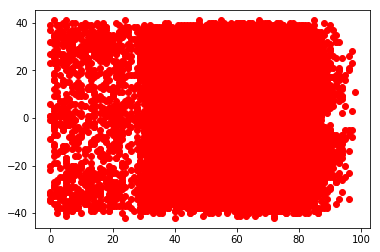

In [42]:
#Flip the Signs --- Because it Needs to be on One Side

Shot_Plays['coordinates.y'] = np.where(Shot_Plays['coordinates.x'] < 0 ,Shot_Plays['coordinates.y'] * -1,Shot_Plays['coordinates.y'])
Shot_Plays['coordinates.x'] = np.where(Shot_Plays['coordinates.x'] < 0 ,Shot_Plays['coordinates.x'] * -1,Shot_Plays['coordinates.x'])
#Shot_Plays = Shot_Plays[Shot_Plays['coordinates.x'] != 89]
Shot_Plays = Shot_Plays[Shot_Plays['coordinates.y'] != 0]

plt.plot(Shot_Plays['coordinates.x'],Shot_Plays['coordinates.y'],'ro')

In [43]:
Goals = Shot_Plays[Shot_Plays['result.eventTypeId'].isin(['GOAL'])]
Non_Goal_Shots = Shot_Plays[Shot_Plays['result.eventTypeId'].isin(['SHOT','BLOCKED_SHOT','MISSED_SHOT'])]

,coordinates.x,coordinates.y
25,78.0,1.0
47,70.0,11.0
53,77.0,-4.0
114,93.0,-11.0
183,52.0,-21.0


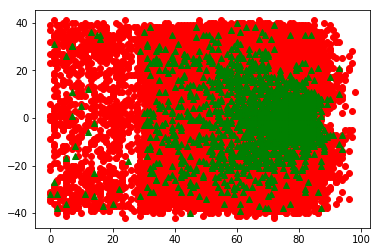

In [44]:
#Where Did the Goals Happen

plt.plot(Non_Goal_Shots['coordinates.x'],Non_Goal_Shots['coordinates.y'],'ro')
plt.plot(Goals['coordinates.x'],Goals['coordinates.y'],'g^')
Goals[['coordinates.x','coordinates.y']].head(5)

In [74]:
Shot_Plays['result.secondaryType'].value_counts()

Wrist Shot     12728
Slap Shot       3729
Snap Shot       3245
Backhand        1801
Tip-In          1094
Deflected        356
Wrap-around      213
Name: result.secondaryType, dtype: int64

In [45]:
#Get THe Goal coordiantes

Goal1CoordinateX1 = 89
Goal1CoordinatePP = 3
Goal1CoordinateNP = -3
Goal1CoordinateCG = 0


In [46]:
#Hyponetuse = Distnace of Shot

def distance(x1, y1,x2,y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

,Distance_To_Goal,coordinates.x,coordinates.y
0,65.795137,29.0,27.0
1,58.940648,32.0,15.0
2,44.687806,60.0,-34.0
3,46.861498,53.0,-30.0
4,45.276926,56.0,31.0


In [ ]:
#Negative Post to Positive Post CALCS 

Shot_Plays['Distance_To_Goal'] = Shot_Plays.apply(lambda x: math.hypot(Goal1CoordinateX1 - x['coordinates.x'],x['coordinates.y']),axis =1)
Shot_Plays['Shot_Distance_NP'] = Shot_Plays.apply(lambda x: distance(x['coordinates.x'],x['coordinates.y'],Goal1CoordinateX1,Goal1CoordinateNP),axis = 1)
Shot_Plays['Shot_Distance_PP'] = Shot_Plays.apply(lambda x: distance(x['coordinates.x'],x['coordinates.y'],Goal1CoordinateX1,Goal1CoordinatePP),axis = 1)
Shot_Plays[['coordinates.x','coordinates.y','Shot_Distance_PP','Distance_To_Goal','Shot_Distance_NP']].head(10)

In [65]:
#Shot Angles -- Pretty Sure There is Something Wrong Here But We Can Put it Together Later

Shot_Plays['Shot_Angle'] = Shot_Plays.apply(lambda x: abs(math.degrees(math.sin(x['coordinates.y']/(Goal1CoordinateX1 - x['coordinates.x'])))),axis =1)

ZeroDivisionError: ('float division by zero', u'occurred at index 845')

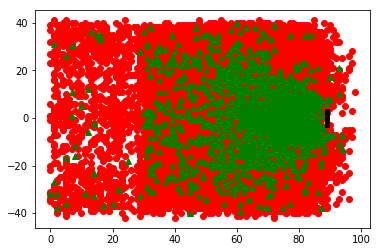

In [58]:
#Draw Again

plt.plot(Non_Goal_Shots['coordinates.x'],Non_Goal_Shots['coordinates.y'],'ro')
plt.plot(Goals['coordinates.x'],Goals['coordinates.y'],'g^')
plt.plot([Goal1CoordinateX1, Goal1CoordinateX1 ], [Goal1CoordinateNP, Goal1CoordinatePP], 'k-', lw=5)
#plt.plot(x=64, y=25, style='k-', label='point',lw = 10)
#plt.plot(x = 54,y = 25,'k-') 


In [60]:
#Shot Angle, Angle of Shot to CENTER of Goal
#Shot_Plays[['coordinates.x','coordinates.y','Shot_Distance_PP','Distance_To_Goal','Shot_Distance_NP','Shot_Angle']]
#Shot_Plays[['coordinates.x','coordinates.y','Shot_Distance_PP','Distance_To_Goal','Shot_Distance_NP','Shot_Angle']][Shot_Plays['Shot_Angle'] == np.max(Shot_Plays.Shot_Angle)]

,coordinates.x,coordinates.y,Shot_Distance_PP,Distance_To_Goal,Shot_Distance_NP,Shot_Angle
845,89.0,-6.0,9.0,6.0,3.0,48.212736
878,89.0,20.0,17.0,20.0,23.0,48.212736
1418,89.0,6.0,3.0,6.0,9.0,48.212736
1945,89.0,26.0,23.0,26.0,29.0,48.212736
2027,89.0,11.0,8.0,11.0,14.0,48.212736
2112,89.0,23.0,20.0,23.0,26.0,48.212736
3036,89.0,7.0,4.0,7.0,10.0,48.212736
3135,89.0,-13.0,16.0,13.0,10.0,48.212736
4188,89.0,-9.0,12.0,9.0,6.0,48.212736
4205,89.0,8.0,5.0,8.0,11.0,48.212736


logp = -235.52, ||grad|| = 3.1662e+07: 100%|██████████| 156/156 [00:43<00:00,  3.62it/s] 
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [sigma_b_log__]
>Metropolis: [mu_b]
>Metropolis: [sigma_a_log__]
>Metropolis: [mu_a]
  2%|▏         | 44/2500 [06:02<5:36:52,  8.23s/it]
Process PoolWorker-3:
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda2/lib/python2.7/multiprocessing/pool.py", line 117, in worker
    put((job, i, result))
  File "/anaconda2/lib/python2.7/site-packages/joblib/pool.py", line 384, in put
    wlock_acquire()
KeyboardInterrupt
Process PoolWorker-5:
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  Fil

#More Screwing

In [13]:
Total_Plays['result.eventTypeId'].value_counts()

FACEOFF              22319
SHOT                 21633
STOP                 17730
HIT                  15927
BLOCKED_SHOT         11092
MISSED_SHOT           9066
GIVEAWAY              6679
TAKEAWAY              5295
PENALTY               2717
GOAL                  2139
PERIOD_START          1241
PERIOD_READY          1238
PERIOD_END            1237
PERIOD_OFFICIAL       1237
GAME_SCHEDULED         369
GAME_END               368
CHALLENGE               58
SHOOTOUT_COMPLETE       37
GAME_OFFICIAL            9
EARLY_INT_START          1
EARLY_INT_END            1
Name: result.eventTypeId, dtype: int64

In [14]:
Total_Plays[Total_Plays['result.eventTypeId'] == 'BLOCKED_SHOT']['result.description']

15         David Backes blocked shot from Travis Sanheim
16        Danton Heinen blocked shot from Travis Sanheim
20          Michael Raffl blocked shot from Anders Bjork
22           Jakub Voracek blocked shot from Zdeno Chara
35        Ivan Provorov blocked shot from David Pastrnak
36         Michael Raffl blocked shot from Brad Marchand
49          Michael Raffl blocked shot from Anders Bjork
51          Riley Nash blocked shot from Brandon Manning
81        Matt Grzelcyk blocked shot from Wayne Simmonds
99              Robert Hagg blocked shot from Torey Krug
106       Wayne Simmonds blocked shot from Matt Grzelcyk
108         Brandon Manning blocked shot from Riley Nash
119          Danton Heinen blocked shot from Robert Hagg
136    David Backes blocked shot from Shayne Gostisbe...
151    Noel Acciari blocked shot from Shayne Gostisbe...
153          Jordan Weal blocked shot from Brandon Carlo
154          Brandon Carlo blocked shot from Jordan Weal
160         Zdeno Chara blocked

In [20]:
#SEt Goals 

Goals = plays[plays['result.eventTypeId'].isin(['GOAL'])]
np.max(Goals['coordinates.x'])

NameError: name 'plays' is not defined

In [19]:
Shot_Plays[['coordinates.x','coordinates.y']]


,coordinates.x,coordinates.y
4,29.0,27.0
7,-32.0,-15.0
8,60.0,-34.0
11,-53.0,30.0
12,-56.0,-31.0
15,-55.0,-21.0
16,-38.0,-34.0
20,47.0,-7.0
22,52.0,37.0
24,-81.0,-2.0


In [119]:
#plays['players']#.apply(lambda x: json_normalize(x))

0                                                    NaN
1                                                    NaN
2                                                    NaN
3      [{u'player': {u'fullName': u'Mathew Barzal', u...
4      [{u'player': {u'fullName': u'Adam Pelech', u'l...
5      [{u'player': {u'fullName': u'Andrew Ladd', u'l...
6      [{u'player': {u'fullName': u'Andrew Ladd', u'l...
7      [{u'player': {u'fullName': u'Thomas Hickey', u...
8      [{u'player': {u'fullName': u'Thomas Hickey', u...
9      [{u'player': {u'fullName': u'Charlie McAvoy', ...
10     [{u'player': {u'fullName': u'Scott Mayfield', ...
11     [{u'player': {u'fullName': u'Scott Mayfield', ...
12     [{u'player': {u'fullName': u'Scott Mayfield', ...
13     [{u'player': {u'fullName': u'Scott Mayfield', ...
14     [{u'player': {u'fullName': u'Brandon Carlo', u...
15     [{u'player': {u'fullName': u'Jordan Eberle', u...
16     [{u'player': {u'fullName': u'Jordan Eberle', u...
17     [{u'player': {u'fullName

In [142]:
Goals = plays[plays['result.eventTypeId'].isin(['GOAL'])]
Goals.reset_index(inplace = True)

https://ejhxb44622.i.lithium.com/t5/image/serverpage/image-id/2345i9C9ED39EA4669452/image-size/large?v=1.0&px=999

In [147]:
Goals.iloc[1,]

index                                                                       51
about.dateTime                                            2018-01-03T00:23:41Z
about.eventId                                                               78
about.eventIdx                                                              51
about.goals.away                                                             1
about.goals.home                                                             1
about.ordinalNum                                                           1st
about.period                                                                 1
about.periodTime                                                         09:30
about.periodTimeRemaining                                                10:30
about.periodType                                                       REGULAR
coordinates.x                                                               76
coordinates.y                                       

18    NaN
23    NaN
27    NaN
40    NaN
48    NaN
68    NaN
80    NaN
103   NaN
108   NaN
134   NaN
152   NaN
175   NaN
179   NaN
184   NaN
208   NaN
213   NaN
242   NaN
245   NaN
278   NaN
304   NaN
308   NaN
315   NaN
Name: coordinates.x, dtype: float64